In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras import models, layers, optimizers
import datetime

# Load historical stock price data for three stocks
stock1_ticker = 'VOO'  # Example: Apple Inc.
stock2_ticker = 'META'  # Example: Microsoft Corp.
stock3_ticker = 'MSFT'  # Example: Alphabet Inc.

data1 = yf.download(stock1_ticker, start='2010-01-01', end='2025-01-01')
data2 = yf.download(stock2_ticker, start='2010-01-01', end='2025-01-01')
data3 = yf.download(stock3_ticker, start='2010-01-01', end='2025-01-01')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Combine the three datasets
data_combined = pd.concat([
    data1[['Close', 'Volume']].rename(columns={'Close': 'Close_Stock1', 'Volume': 'Volume_Stock1'}),
    data2[['Close', 'Volume']].rename(columns={'Close': 'Close_Stock2', 'Volume': 'Volume_Stock2'}),
    data3[['Close', 'Volume']].rename(columns={'Close': 'Close_Stock3', 'Volume': 'Volume_Stock3'})
], axis=1, join='inner').dropna()

# Add time-based features
data_combined['Year'] = data_combined.index.year
data_combined['Month'] = data_combined.index.month
data_combined['Day'] = data_combined.index.day
data_combined['DayOfWeek'] = data_combined.index.dayofweek


In [ ]:
# Preprocess data
features = [
    'Close_Stock1', 'Volume_Stock1',
    'Close_Stock2', 'Volume_Stock2',
    'Close_Stock3', 'Volume_Stock3',
    'Year', 'Month', 'Day', 'DayOfWeek'
]
feature_data = data_combined[features]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(feature_data)

# Prepare sequences for training
sequence_length = 360
train_size = int(len(scaled_data) * 1.0)
train_data = scaled_data[:train_size]

def create_sequences(data, sequence_length):
    x = []
    y = []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])  # Include all features
        y.append(data[i, :6])  # Predict prices and volumes for all three stocks
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data, sequence_length)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0823
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0436
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0116
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0046
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0047
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0040
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040
Epoc

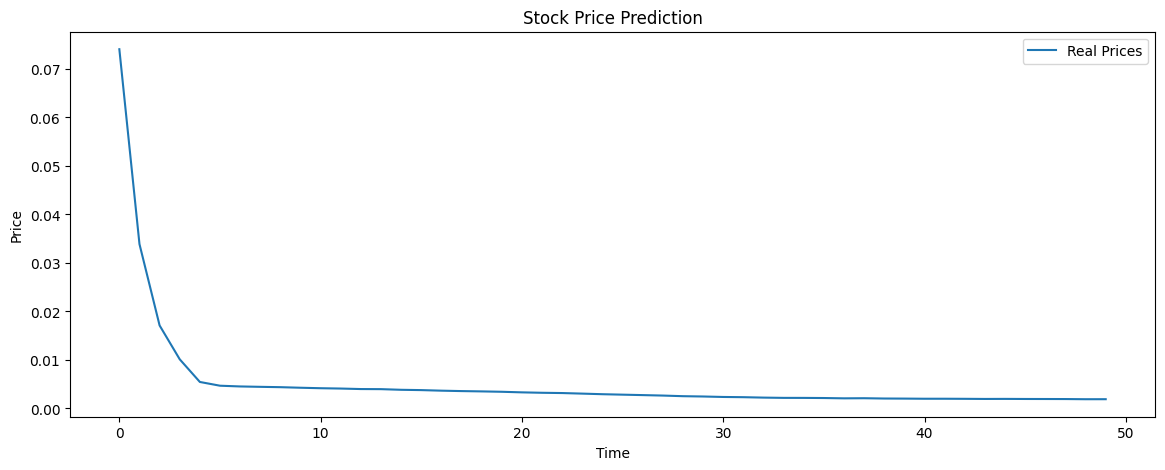

In [ ]:
# Build the CNN-LSTM model
model = Sequential()

# Add Convolutional Layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.01))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.01))
'''
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.01))
model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.01))'''
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.01))


'''model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))'''
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=6))  # Predict prices and volumes for three stocks

# Compile the model

optimizer = optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=500)

losses = history.history['loss']

plt.figure(figsize=(14, 5))
plt.plot(losses, label='Real Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

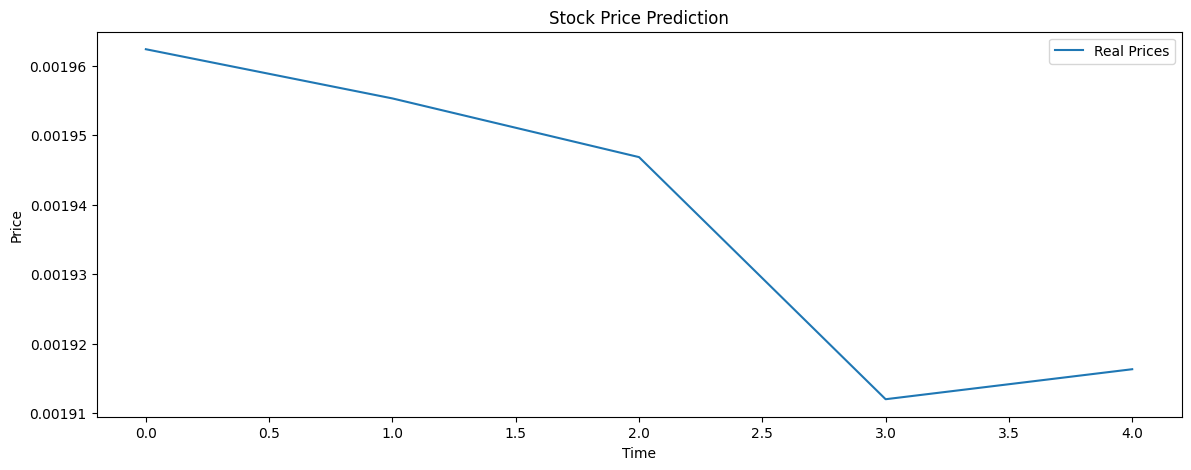

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(losses[-5:], label='Real Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


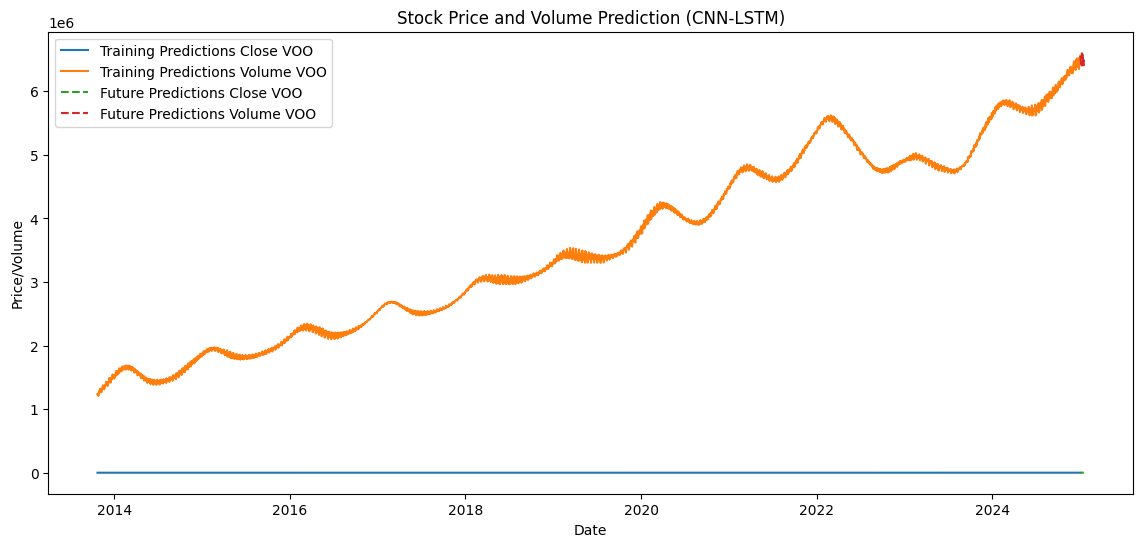

Prediction and visualization complete.


In [ ]:
# Predict prices and volumes on the training dataset
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(
    np.hstack([train_predictions, np.zeros((train_predictions.shape[0], scaled_data.shape[1] - 6))])
)[:, :6]

# Future predictions
last_sequence = scaled_data[-sequence_length:]  # Take the last sequence from the dataset
future_days = 15
predicted_prices_volumes = []

for _ in range(future_days):
    # Reshape last_sequence for prediction
    input_data = np.expand_dims(last_sequence, axis=0)
    predicted = model.predict(input_data)
    predicted_prices_volumes.append(predicted[0])

    # Update last_sequence with predicted value
    new_row = np.zeros((1, last_sequence.shape[1]))
    new_row[0, :6] = predicted  # Add predicted 'Close' and 'Volume' for three stocks
    new_row[0, 6:] = last_sequence[-1, 6:]  # Copy time features
    last_sequence = np.vstack([last_sequence[1:], new_row])

# Transform predicted values back to original scale
predicted_prices_volumes = scaler.inverse_transform(
    np.hstack([np.array(predicted_prices_volumes), np.zeros((future_days, scaled_data.shape[1] - 6))])
)[:, :6]

# Generate future dates for plotting
last_date = data_combined.index[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# Plot the predictions
plt.figure(figsize=(14, 6))
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 0], label=f'Training Predictions Close {stock1_ticker}')
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 1], label=f'Training Predictions Volume {stock1_ticker}')
plt.plot(future_dates, predicted_prices_volumes[:, 0], label=f'Future Predictions Close {stock1_ticker}', linestyle='--')
plt.plot(future_dates, predicted_prices_volumes[:, 1], label=f'Future Predictions Volume {stock1_ticker}', linestyle='--')
plt.title('Stock Price and Volume Prediction (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Price/Volume')
plt.legend()
plt.show()

print("Prediction and visualization complete.")

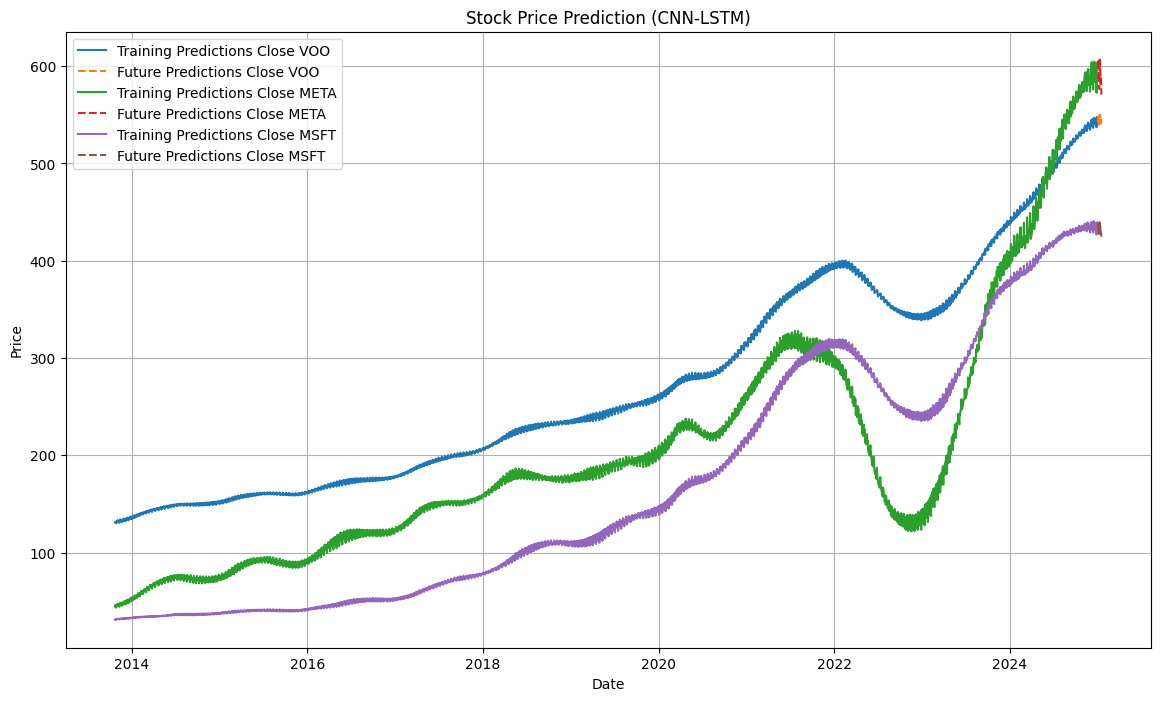

In [ ]:
# Combined plot for all three stocks
plt.figure(figsize=(14, 8))

# Stock 1
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 0], label=f'Training Predictions Close {stock1_ticker}')
plt.plot(future_dates, predicted_prices_volumes[:, 0], label=f'Future Predictions Close {stock1_ticker}', linestyle='--')

# Stock 2
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 2], label=f'Training Predictions Close {stock2_ticker}')
plt.plot(future_dates, predicted_prices_volumes[:, 2], label=f'Future Predictions Close {stock2_ticker}', linestyle='--')

# Stock 3
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 4], label=f'Training Predictions Close {stock3_ticker}')
plt.plot(future_dates, predicted_prices_volumes[:, 4], label=f'Future Predictions Close {stock3_ticker}', linestyle='--')

# Customize the plot
plt.title('Stock Price Prediction (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


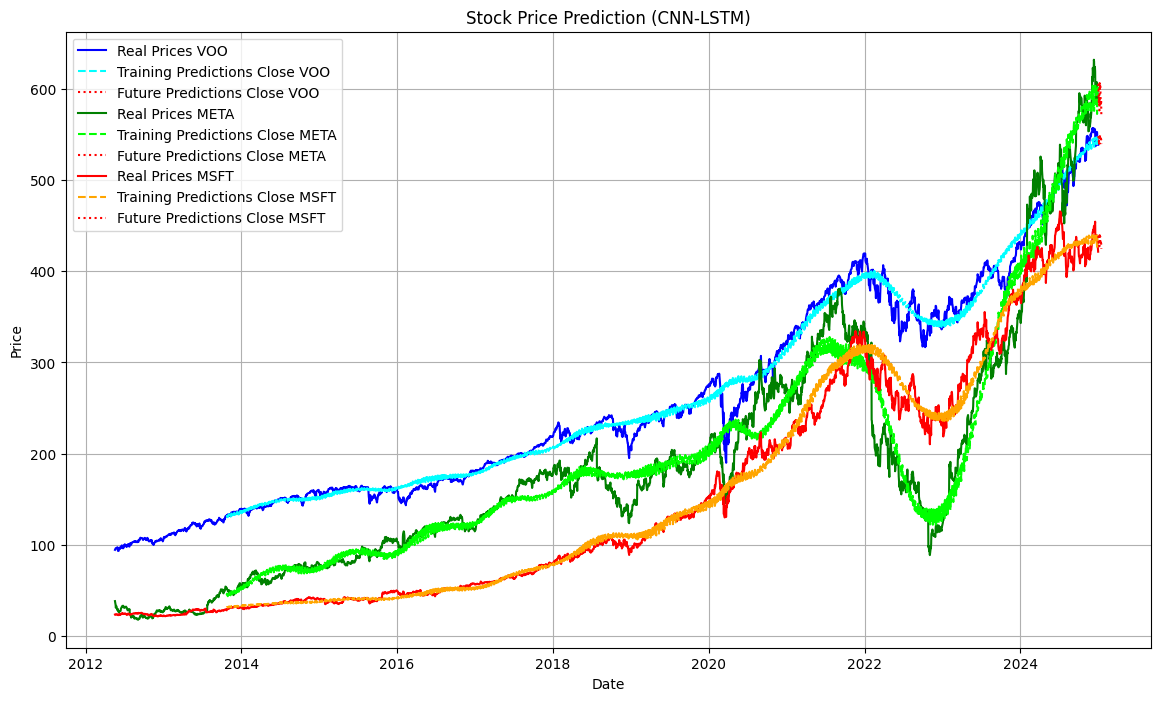

In [ ]:
# Combined plot for all three stocks with real prices
plt.figure(figsize=(14, 8))

# Stock 1
plt.plot(data_combined.index, data_combined['Close_Stock1'], label=f'Real Prices {stock1_ticker}', color='blue')
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 0], label=f'Training Predictions Close {stock1_ticker}', linestyle='--', color='cyan')
plt.plot(future_dates, predicted_prices_volumes[:, 0], label=f'Future Predictions Close {stock1_ticker}', linestyle=':', color='red')

# Stock 2
plt.plot(data_combined.index, data_combined['Close_Stock2'], label=f'Real Prices {stock2_ticker}', color='green')
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 2], label=f'Training Predictions Close {stock2_ticker}', linestyle='--', color='lime')
plt.plot(future_dates, predicted_prices_volumes[:, 2], label=f'Future Predictions Close {stock2_ticker}', linestyle=':', color='red')

# Stock 3
plt.plot(data_combined.index, data_combined['Close_Stock3'], label=f'Real Prices {stock3_ticker}', color='red')
plt.plot(data_combined.index[sequence_length:train_size], train_predictions[:, 4], label=f'Training Predictions Close {stock3_ticker}', linestyle='--', color='orange')
plt.plot(future_dates, predicted_prices_volumes[:, 4], label=f'Future Predictions Close {stock3_ticker}', linestyle=':', color='red')

# Customize the plot
plt.title('Stock Price Prediction (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


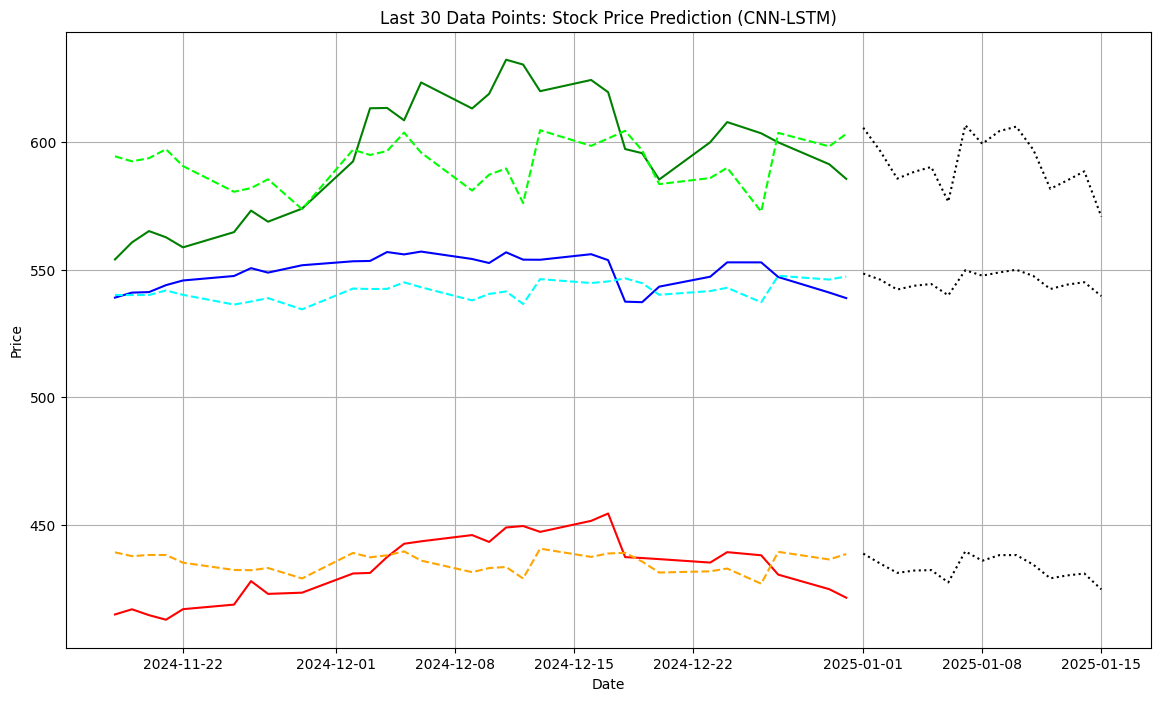

In [ ]:
# Determine the last 30 data points
last_30_real_index = data_combined.index[-30:]
last_30_real_prices_stock1 = data_combined['Close_Stock1'][-30:]
last_30_real_prices_stock2 = data_combined['Close_Stock2'][-30:]
last_30_real_prices_stock3 = data_combined['Close_Stock3'][-30:]

# Combined plot for the last 30 data points
plt.figure(figsize=(14, 8))

# Stock 1
plt.plot(last_30_real_index, last_30_real_prices_stock1, label=f'Real Prices {stock1_ticker}', color='blue')
plt.plot(last_30_real_index, train_predictions[-30:, 0], label=f'Training Predictions Close {stock1_ticker}', linestyle='--', color='cyan')
plt.plot(future_dates[:30], predicted_prices_volumes[:30, 0], label=f'Future Predictions Close {stock1_ticker}', linestyle=':', color='black')

# Stock 2
plt.plot(last_30_real_index, last_30_real_prices_stock2, label=f'Real Prices {stock2_ticker}', color='green')
plt.plot(last_30_real_index, train_predictions[-30:, 2], label=f'Training Predictions Close {stock2_ticker}', linestyle='--', color='lime')
plt.plot(future_dates[:30], predicted_prices_volumes[:30, 2], label=f'Future Predictions Close {stock2_ticker}', linestyle=':', color='black')

# Stock 3
plt.plot(last_30_real_index, last_30_real_prices_stock3, label=f'Real Prices {stock3_ticker}', color='red')
plt.plot(last_30_real_index, train_predictions[-30:, 4], label=f'Training Predictions Close {stock3_ticker}', linestyle='--', color='orange')
plt.plot(future_dates[:30], predicted_prices_volumes[:30, 4], label=f'Future Predictions Close {stock3_ticker}', linestyle=':', color='black')

# Customize the plot
plt.title('Last 30 Data Points: Stock Price Prediction (CNN-LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend('',frameon=False)
plt.grid(True)
plt.show()


In [1]:

last_30_real_prices_stock1 = data_combined['Close_Stock1'][-1:]
last_30_real_prices_stock2 = data_combined['Close_Stock2'][-1:]
last_30_real_prices_stock3 = data_combined['Close_Stock3'][-1:]

print(last_30_real_prices_stock1)

print(last_30_real_prices_stock2)

print(last_30_real_prices_stock3)

NameError: name 'data_combined' is not defined